In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')


## 1. Load Dataset

In [23]:
print("Loading bacteria dataset...")
df = pd.read_csv('../data/mimedb_microbes_v1.csv')
df=df[df["superkingdom"]=="Bacteria"]
print(f"Dataset shape: {df.shape}")

Loading bacteria dataset...
Dataset shape: (1842, 39)


## 2. Feature Selection

In [24]:
# Fixing null value of target class
df['human_pathogen'] = df['human_pathogen'].fillna(0).astype(int)

print("\nTarget distribution:")
pathogen_counts = df['human_pathogen'].value_counts()
print(pathogen_counts)
print(f"Percentage of pathogenic bacteria: {pathogen_counts[1]/len(df)*100:.2f}%")

print("\nSelecting relevant features...")

features = [
    'phylum', 'superkingdom', 'gram', 'oxygen_requirement',
    'shape', 'number_of_membranes', 'optimal_temperature',
    'klass', 'order', 'family', 'genus', 'mobility',
    'flagella_presence', 'temperature_range', 'habitat',
    'biotic_relationship', 'cell_arrangement', 'sporulation',
    'metabolism', 'energy_source'
]

features = [f for f in features if f in df.columns]
print(f"Selected features ({len(features)}): {features}")

X = df[features].copy()
y = df['human_pathogen']



Target distribution:
human_pathogen
0    1779
1      63
Name: count, dtype: int64
Percentage of pathogenic bacteria: 3.42%

Selecting relevant features...
Selected features (20): ['phylum', 'superkingdom', 'gram', 'oxygen_requirement', 'shape', 'number_of_membranes', 'optimal_temperature', 'klass', 'order', 'family', 'genus', 'mobility', 'flagella_presence', 'temperature_range', 'habitat', 'biotic_relationship', 'cell_arrangement', 'sporulation', 'metabolism', 'energy_source']


## 3. Split the data

In [25]:

print("\nSplitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Splitting data into train and test sets...
Training set: 1473 samples
Test set: 369 samples


## 4.  Preprocessing pipeline

In [26]:

print("\nCreating preprocessing pipeline...")

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)



Creating preprocessing pipeline...
Categorical features: ['phylum', 'superkingdom', 'gram', 'oxygen_requirement', 'shape', 'klass', 'order', 'family', 'genus', 'mobility', 'flagella_presence', 'temperature_range', 'habitat', 'biotic_relationship', 'cell_arrangement', 'sporulation', 'metabolism', 'energy_source']
Numerical features: ['number_of_membranes', 'optimal_temperature']


## 5. Evaluate Func

In [27]:
def evaluate_model(model, X_test, y_test, model_name="Model", save_dir="../ml/plots"):
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, classification_report, roc_auc_score,
        roc_curve, precision_recall_curve, average_precision_score
    )

    os.makedirs(save_dir, exist_ok=True)

    y_pred = model.predict(X_test)

    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        has_predict_proba = True
    except Exception:
        has_predict_proba = False
        y_prob = None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    if has_predict_proba:
        roc_auc = roc_auc_score(y_test, y_prob)
        pr_auc = average_precision_score(y_test, y_prob)
    else:
        roc_auc = np.nan
        pr_auc = np.nan

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if has_predict_proba:
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    plt.style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(10, 8))

    try:
        import seaborn as sns
        plt.subplot()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Non-Pathogenic', 'Pathogenic'],
                   yticklabels=['Non-Pathogenic', 'Pathogenic'])
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
    except ImportError:
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xticks([0, 1], ['Non-Pathogenic', 'Pathogenic'])
        plt.yticks([0, 1], ['Non-Pathogenic', 'Pathogenic'])
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)

        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix_{model_name.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()

    if has_predict_proba:
        plt.figure(figsize=(10, 8))

        fpr, tpr, _ = roc_curve(y_test, y_prob)

        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (area = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                label='Random chance')

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curve - {model_name}', fontsize=14)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_dir}/roc_curve_{model_name.replace(" ", "_").lower()}.png', dpi=300)
        plt.show()

        plt.figure(figsize=(10, 8))

        precision_values, recall_values, _ = precision_recall_curve(y_test, y_prob)

        plt.plot(recall_values, precision_values, color='green', lw=2,
                label=f'PR curve (area = {pr_auc:.3f})')

        baseline = sum(y_test) / len(y_test)
        plt.axhline(y=baseline, color='gray', linestyle='--',
                   label=f'Baseline (prevalence = {baseline:.3f})')

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title(f'Precision-Recall Curve - {model_name}', fontsize=14)
        plt.legend(loc="upper right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_dir}/pr_curve_{model_name.replace(" ", "_").lower()}.png', dpi=300)
        plt.show()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc if has_predict_proba else np.nan,
        'pr_auc': pr_auc if has_predict_proba else np.nan
    }

## 6. Train and evaluate multiple

In [28]:
print("\n= Training and Evaluating Multiple Models =")

all_model_results = []



= Training and Evaluating Multiple Models =


### 6.1 Random Forest with SMOTE



 Training Random Forest model  



Random Forest  Evaluation:
Accuracy: 0.9458
Precision: 0.2667
Recall: 0.3077
F1 Score: 0.2857
ROC AUC: 0.7701
PR AUC: 0.3085

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       356
           1       0.27      0.31      0.29        13

    accuracy                           0.95       369
   macro avg       0.62      0.64      0.63       369
weighted avg       0.95      0.95      0.95       369


Confusion Matrix:
[[345  11]
 [  9   4]]


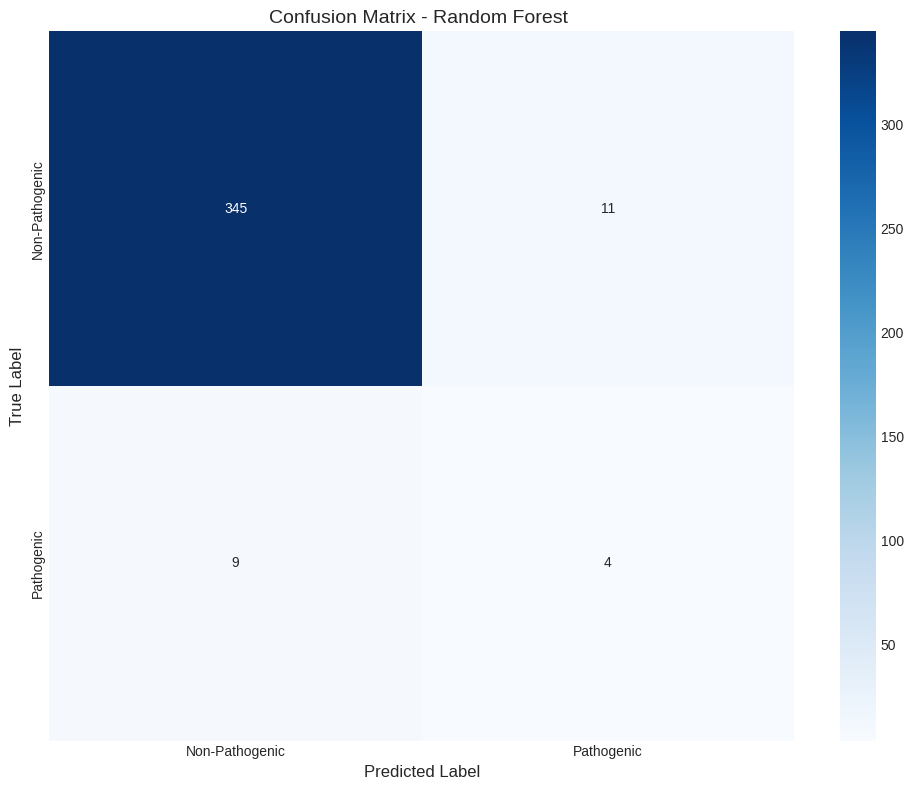

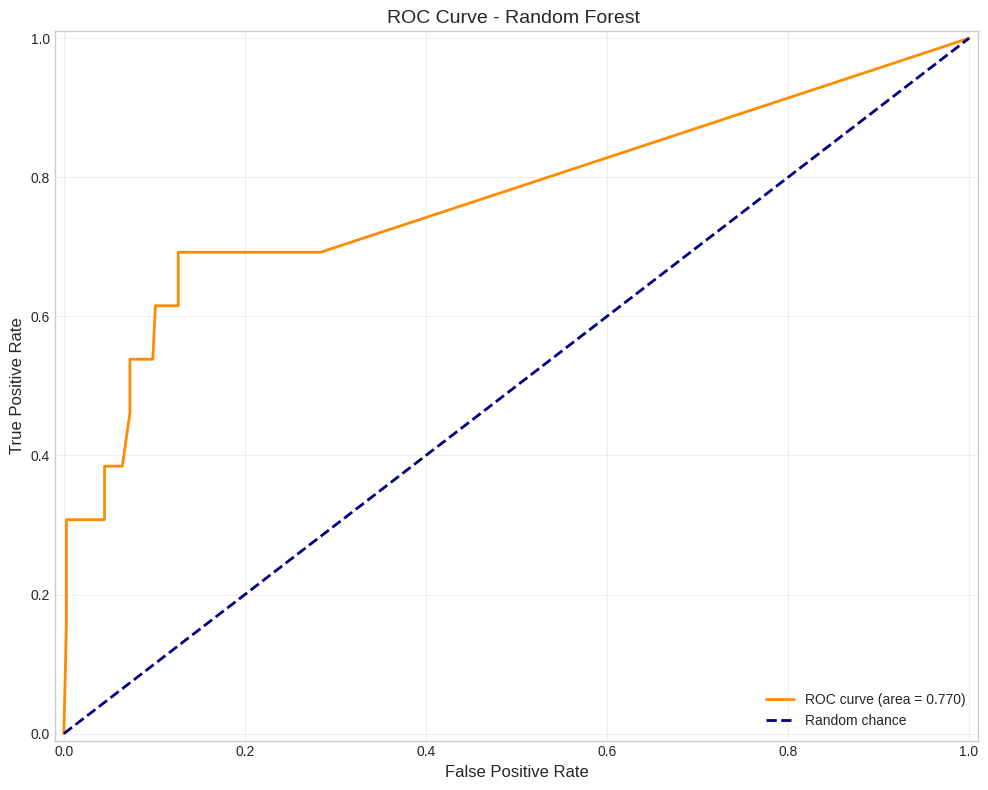

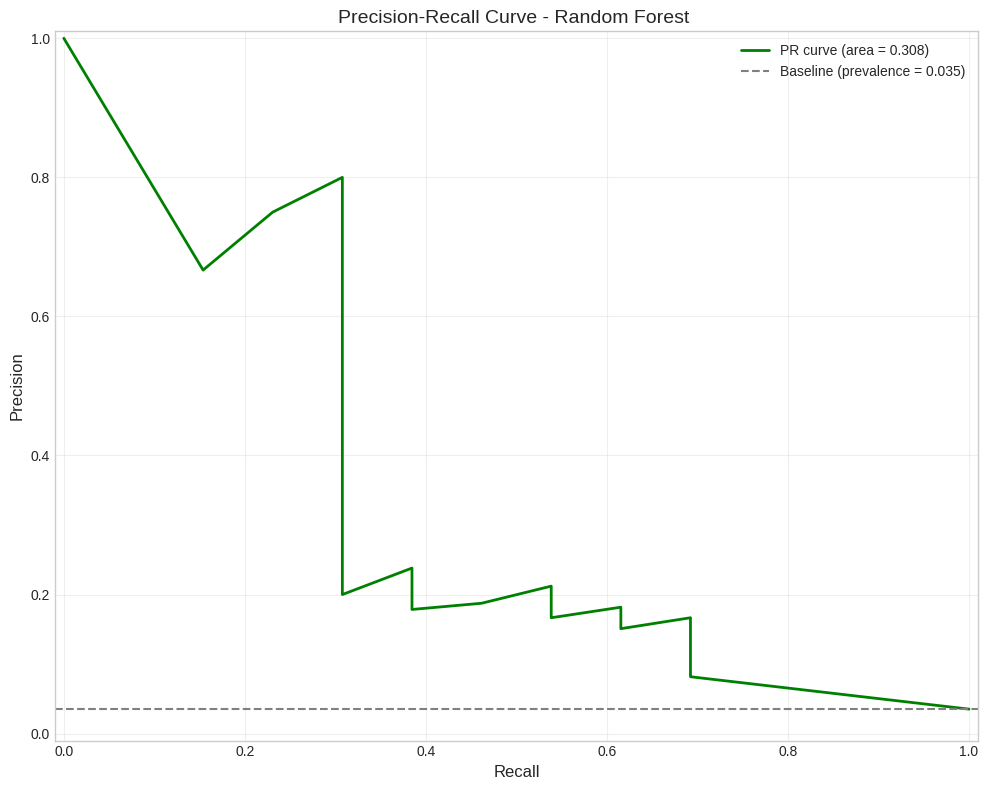

In [29]:
print("\n Training Random Forest model  ")
rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_metrics = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest ")
all_model_results.append(rf_metrics)


### 6.2 Balanced Random Forest


 Training Balanced Random Forest model 

Balanced Random Forest Evaluation:
Accuracy: 0.7371
Precision: 0.0962
Recall: 0.7692
F1 Score: 0.1709
ROC AUC: 0.8698
PR AUC: 0.3801

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.84       356
           1       0.10      0.77      0.17        13

    accuracy                           0.74       369
   macro avg       0.54      0.75      0.51       369
weighted avg       0.96      0.74      0.82       369


Confusion Matrix:
[[262  94]
 [  3  10]]


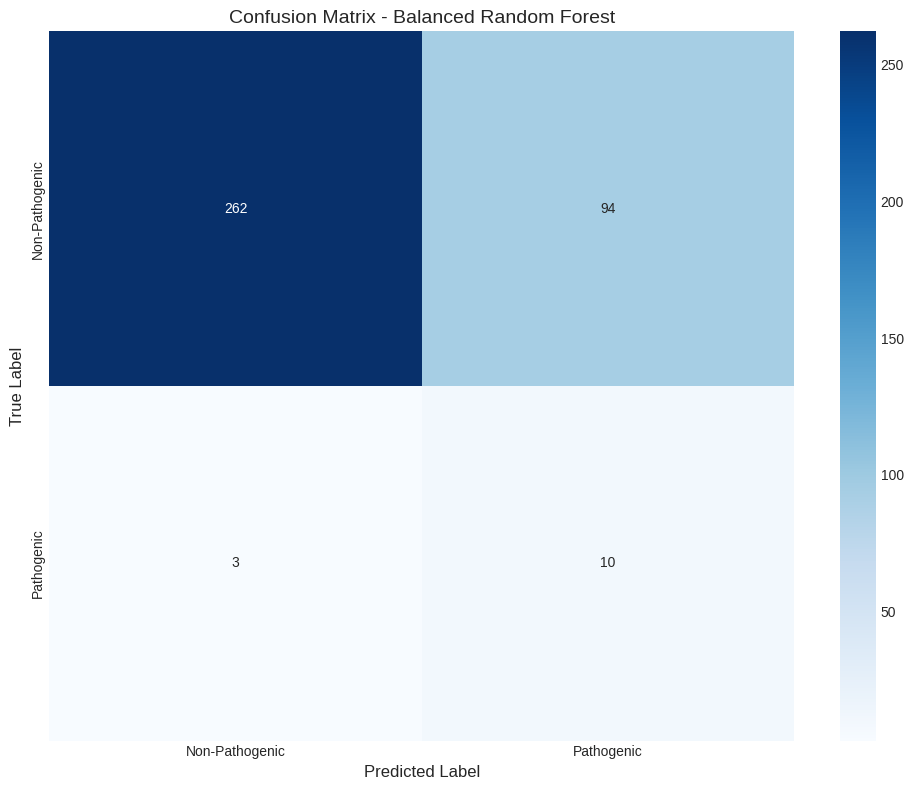

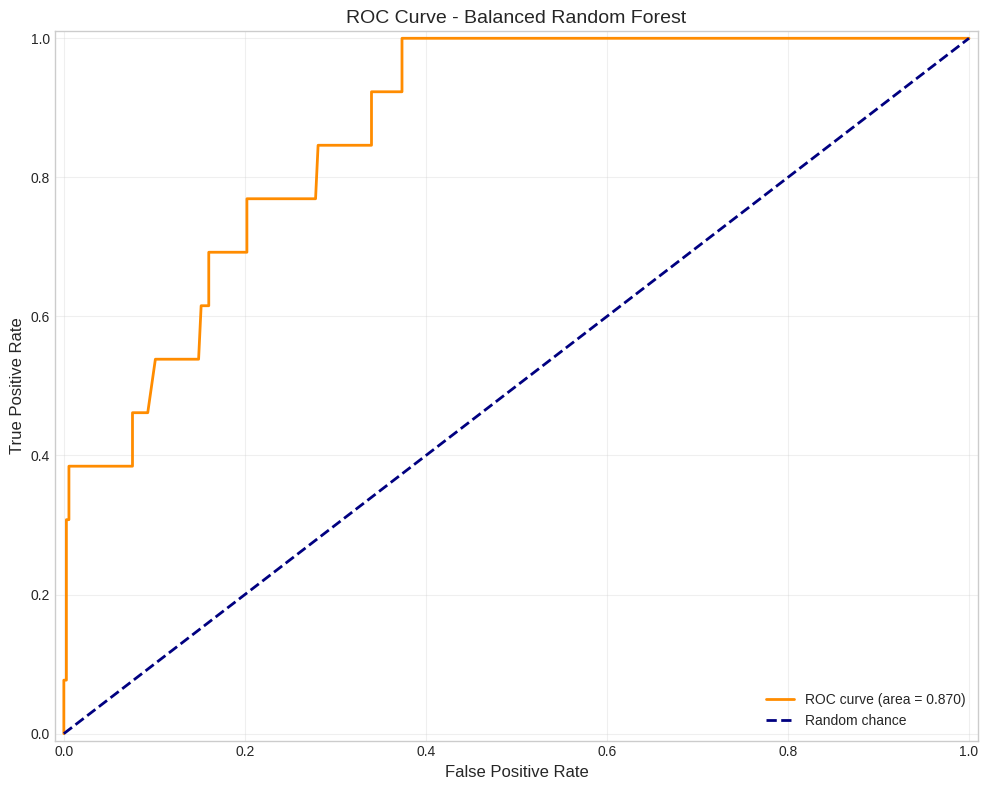

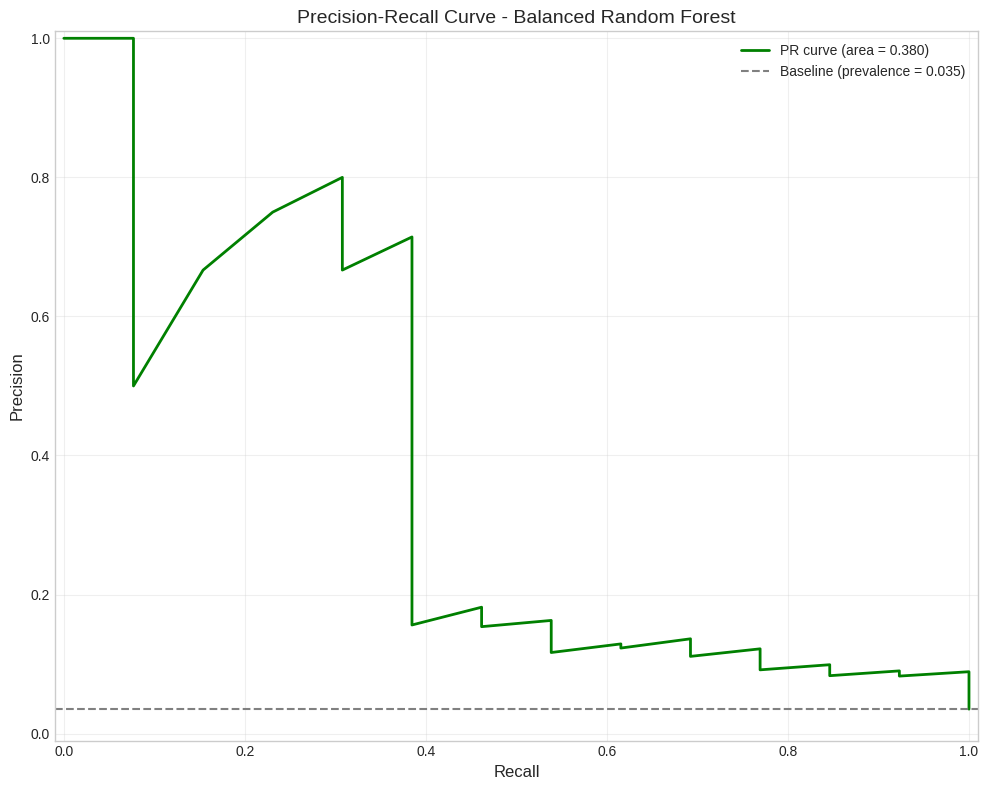

In [30]:

print("\n Training Balanced Random Forest model ")
brf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BalancedRandomForestClassifier(n_estimators=100, random_state=42))
])

brf_pipeline.fit(X_train, y_train)
brf_metrics = evaluate_model(brf_pipeline, X_test, y_test, "Balanced Random Forest")
all_model_results.append(brf_metrics)


### 6.3 AdaBoost 


 Training AdaBoost model  

AdaBoost  Evaluation:
Accuracy: 0.8374
Precision: 0.0566
Recall: 0.2308
F1 Score: 0.0909
ROC AUC: 0.7972
PR AUC: 0.1901

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       356
           1       0.06      0.23      0.09        13

    accuracy                           0.84       369
   macro avg       0.51      0.55      0.50       369
weighted avg       0.94      0.84      0.88       369


Confusion Matrix:
[[306  50]
 [ 10   3]]


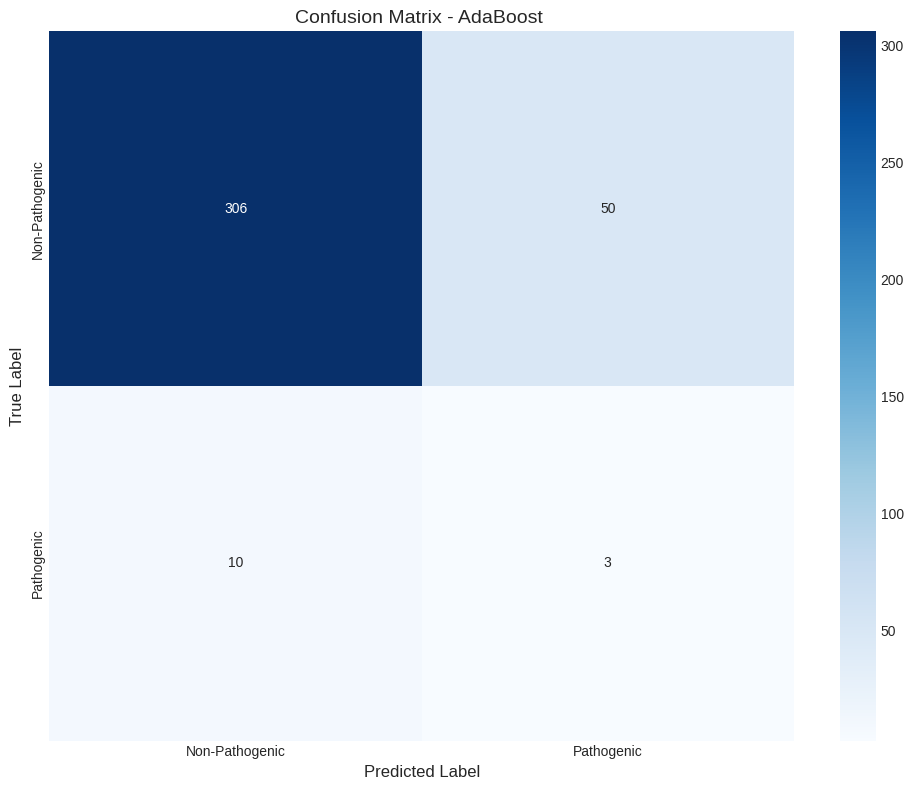

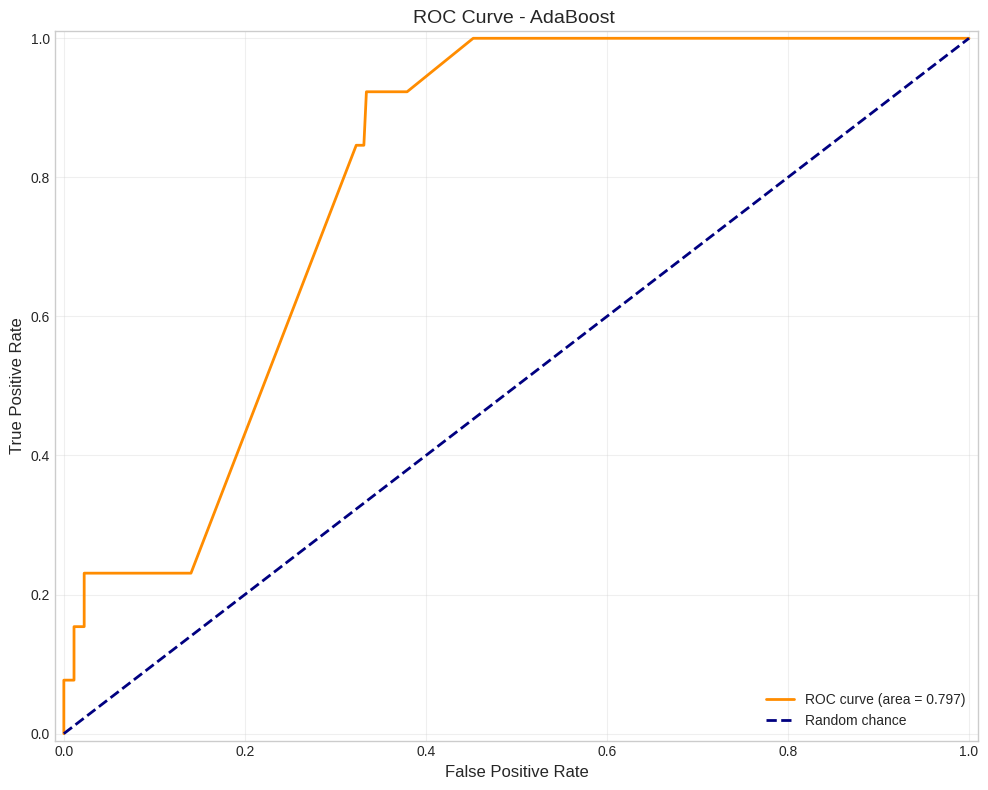

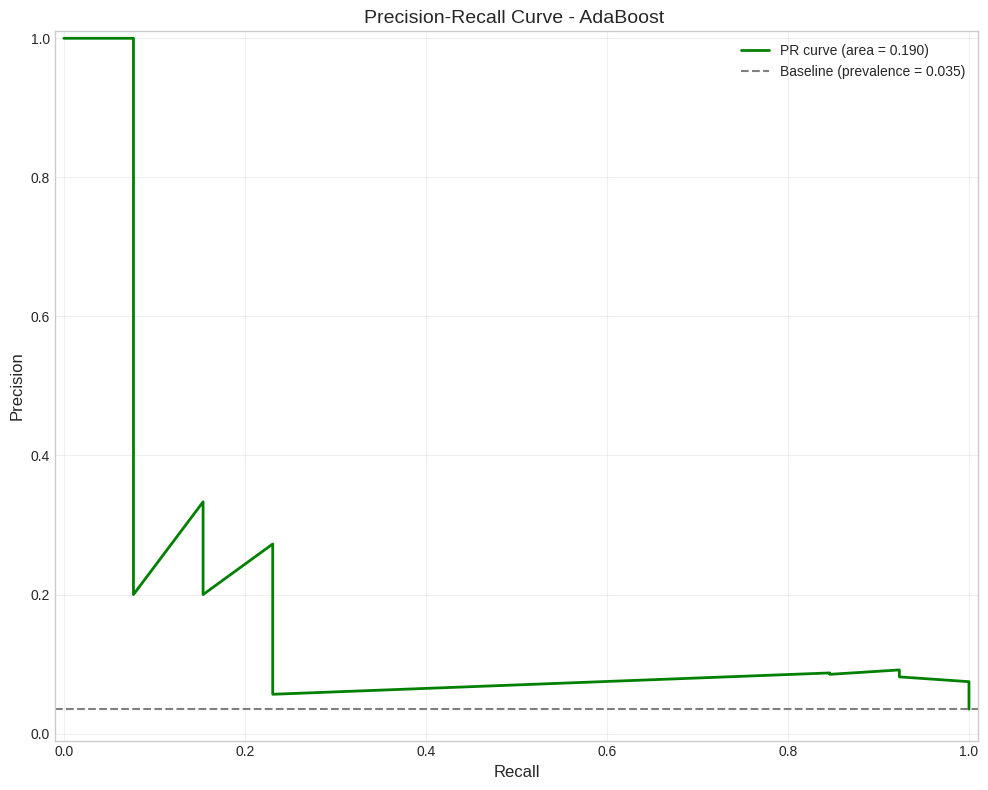

In [31]:
print("\n Training AdaBoost model  ")
ada_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', AdaBoostClassifier(n_estimators=100, random_state=42))
])

ada_pipeline.fit(X_train, y_train)
ada_metrics = evaluate_model(ada_pipeline, X_test, y_test, "AdaBoost ")
all_model_results.append(ada_metrics)


### 6.4 Gradient Boosting 


 Training Gradient Boosting model  

Gradient Boosting  Evaluation:
Accuracy: 0.9241
Precision: 0.1739
Recall: 0.3077
F1 Score: 0.2222
ROC AUC: 0.8379
PR AUC: 0.2486

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       356
           1       0.17      0.31      0.22        13

    accuracy                           0.92       369
   macro avg       0.57      0.63      0.59       369
weighted avg       0.95      0.92      0.93       369


Confusion Matrix:
[[337  19]
 [  9   4]]


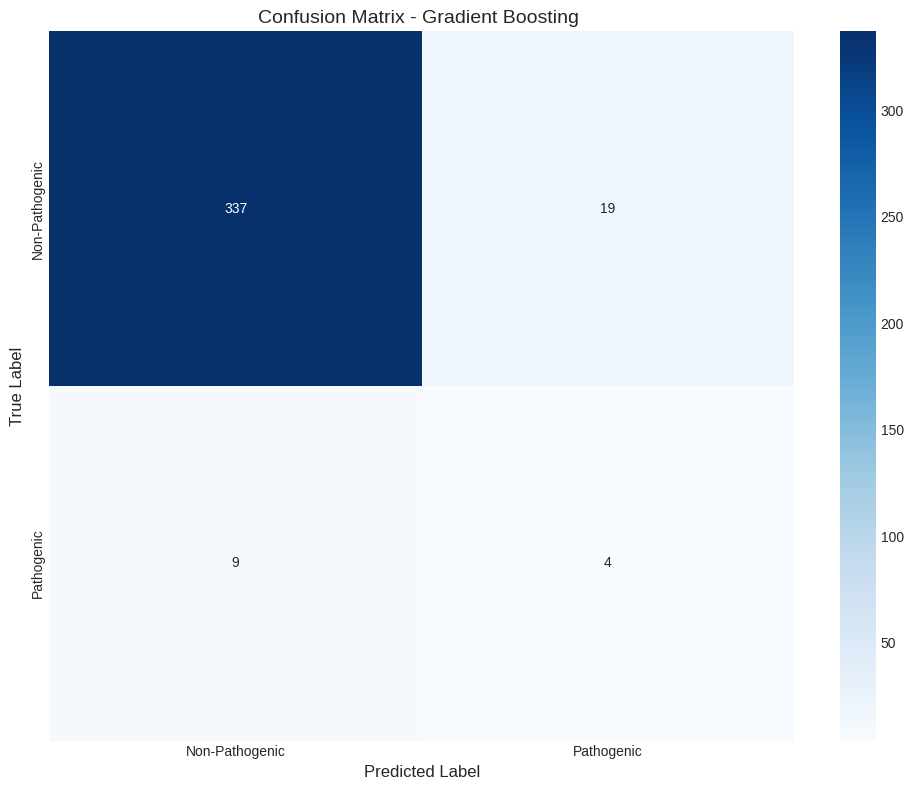

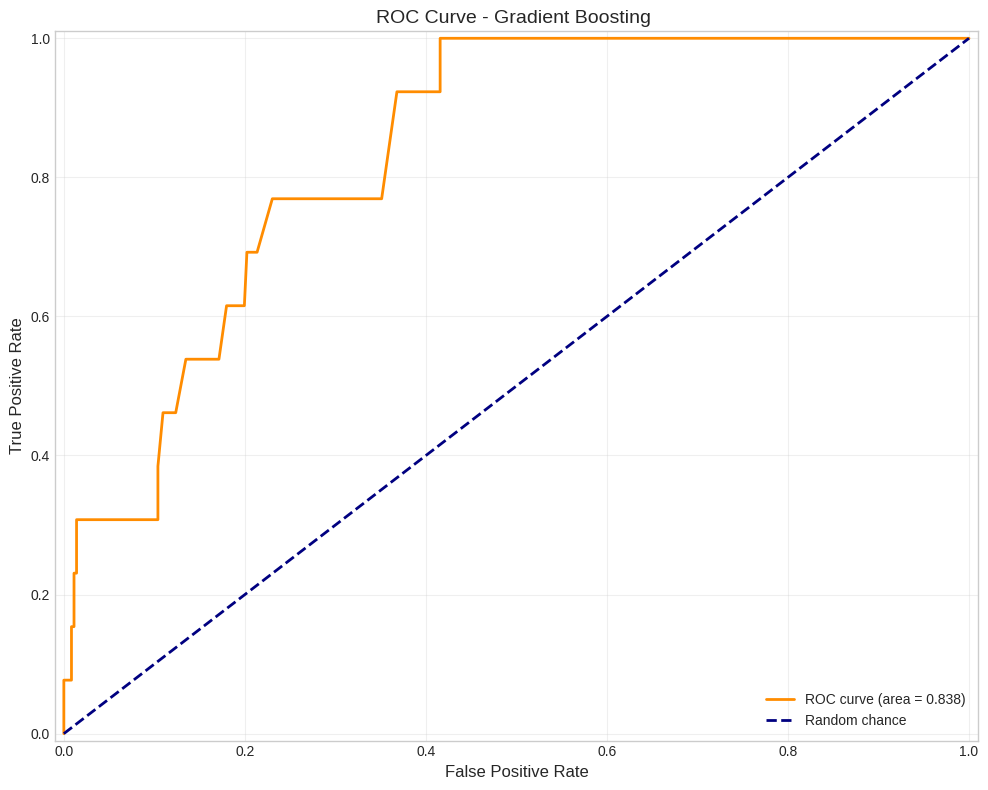

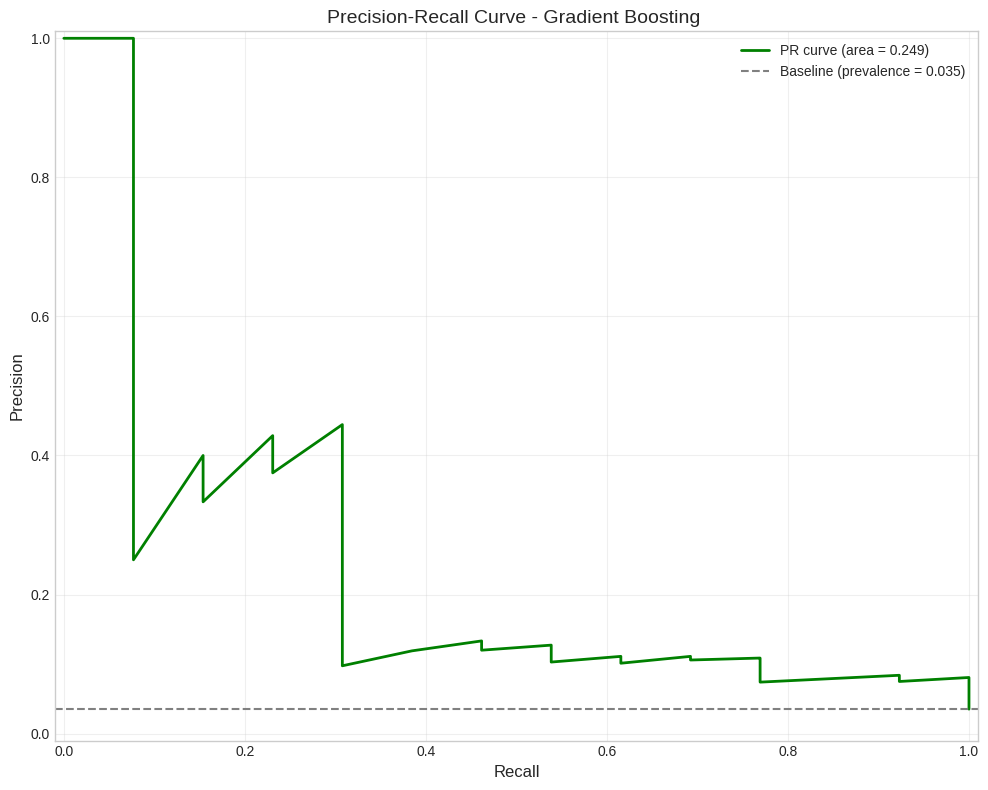

In [32]:
print("\n Training Gradient Boosting model  ")
gb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

gb_pipeline.fit(X_train, y_train)
gb_metrics = evaluate_model(gb_pipeline, X_test, y_test, "Gradient Boosting ")
all_model_results.append(gb_metrics)


### 6.5 XGBoost



 Training XGBoost model  

XGBoost  Evaluation:
Accuracy: 0.9485
Precision: 0.3125
Recall: 0.3846
F1 Score: 0.3448
ROC AUC: 0.8898
PR AUC: 0.4138

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       356
           1       0.31      0.38      0.34        13

    accuracy                           0.95       369
   macro avg       0.64      0.68      0.66       369
weighted avg       0.95      0.95      0.95       369


Confusion Matrix:
[[345  11]
 [  8   5]]


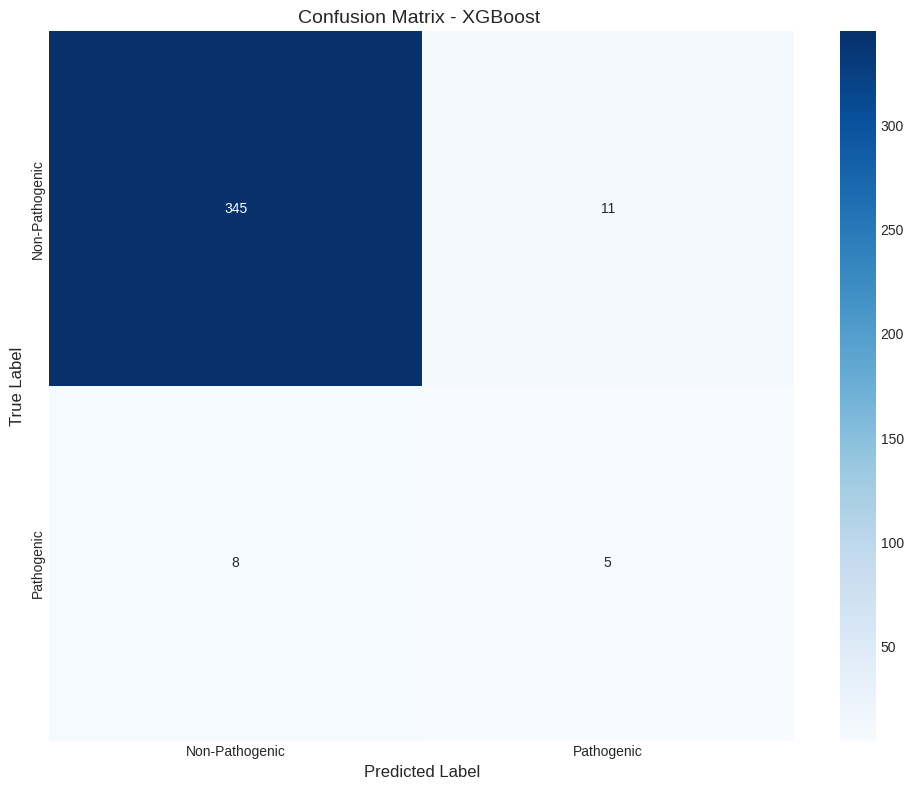

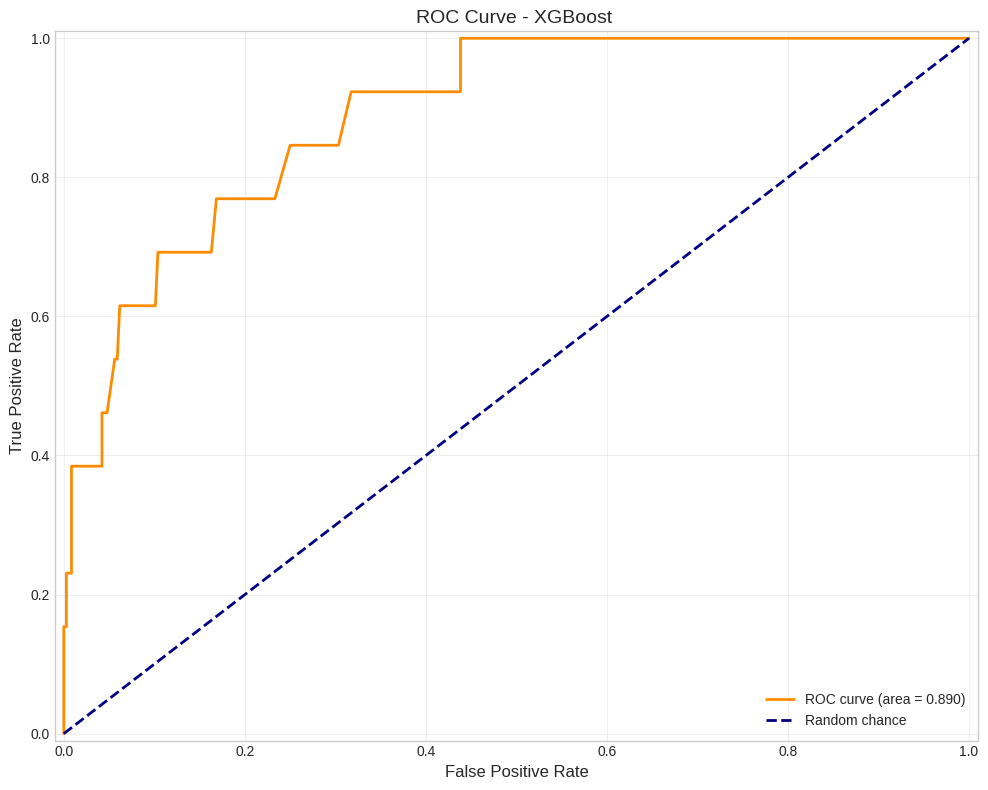

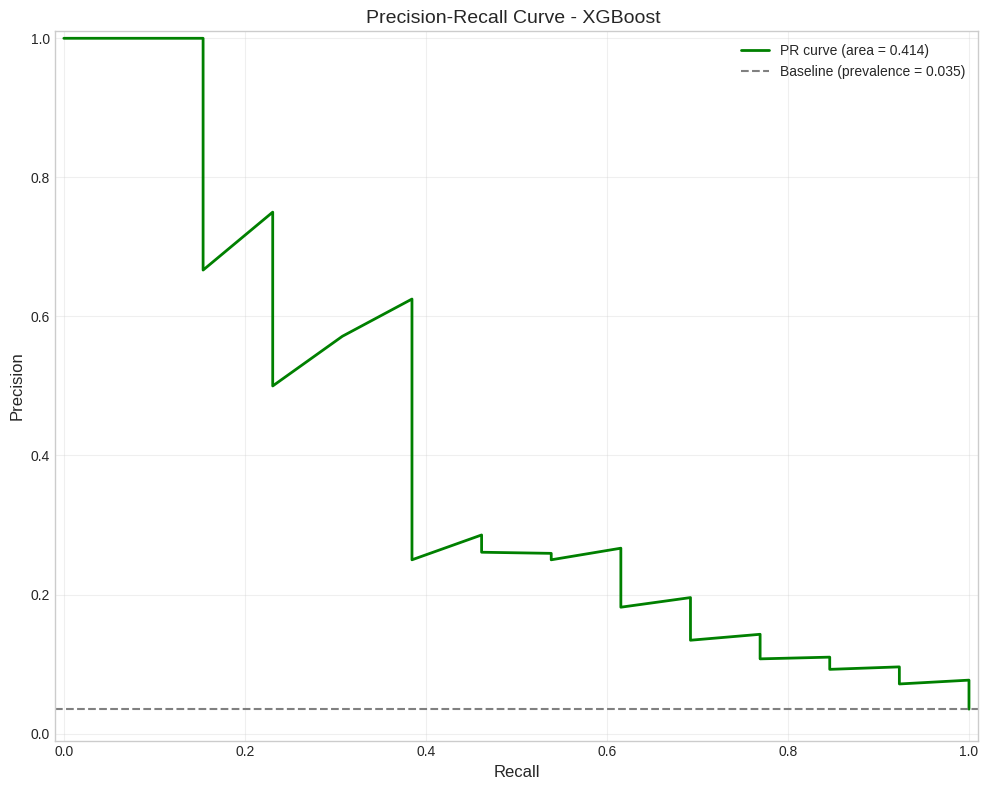

In [33]:
print("\n Training XGBoost model  ")
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(n_estimators=100, random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_metrics = evaluate_model(xgb_pipeline, X_test, y_test, "XGBoost ")
all_model_results.append(xgb_metrics)


### 6.6 Naive Bayes



 Training Naive Bayes model  

Naive Bayes  Evaluation:
Accuracy: 0.8482
Precision: 0.1091
Recall: 0.4615
F1 Score: 0.1765
ROC AUC: 0.6619
PR AUC: 0.0693

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       356
           1       0.11      0.46      0.18        13

    accuracy                           0.85       369
   macro avg       0.54      0.66      0.55       369
weighted avg       0.95      0.85      0.89       369


Confusion Matrix:
[[307  49]
 [  7   6]]


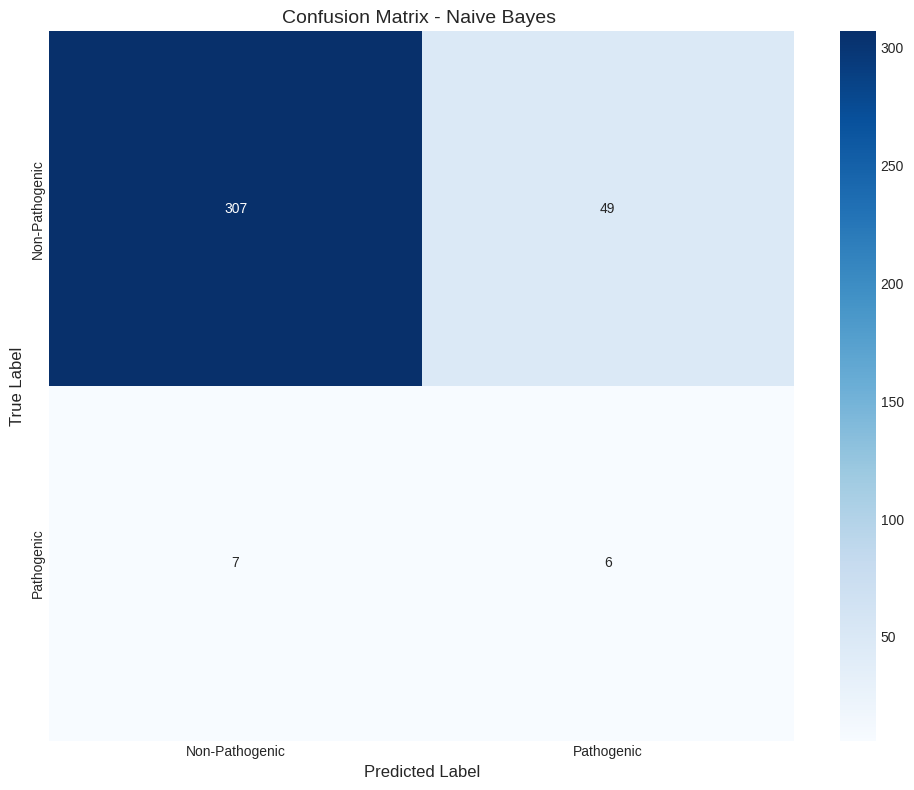

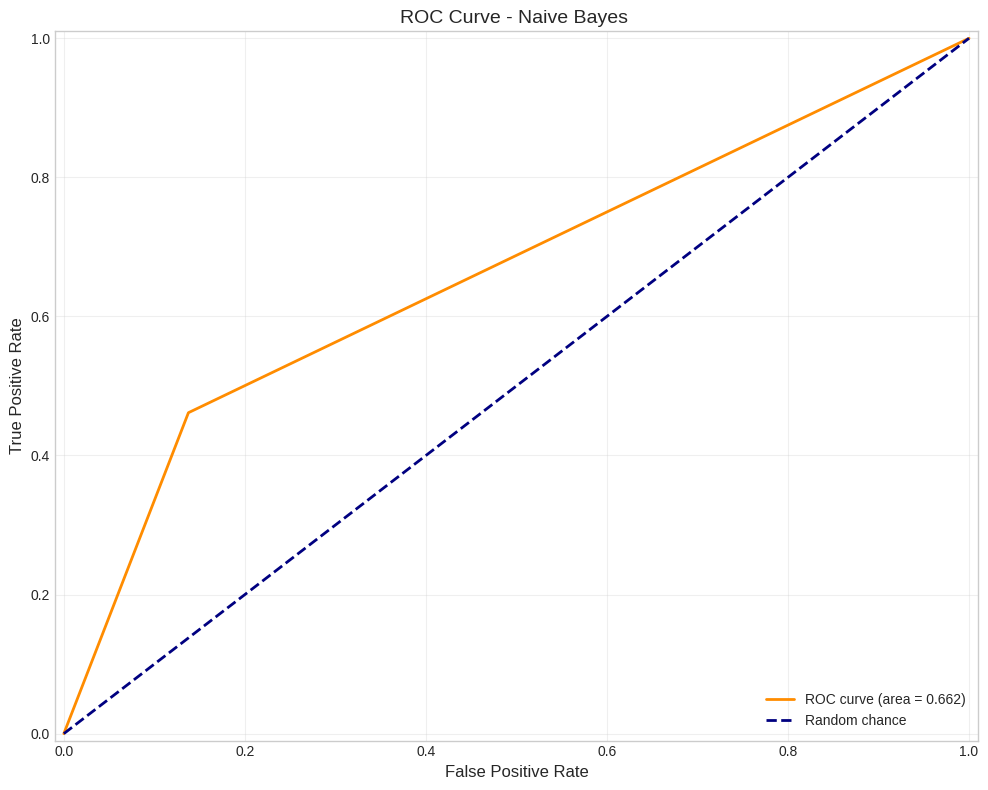

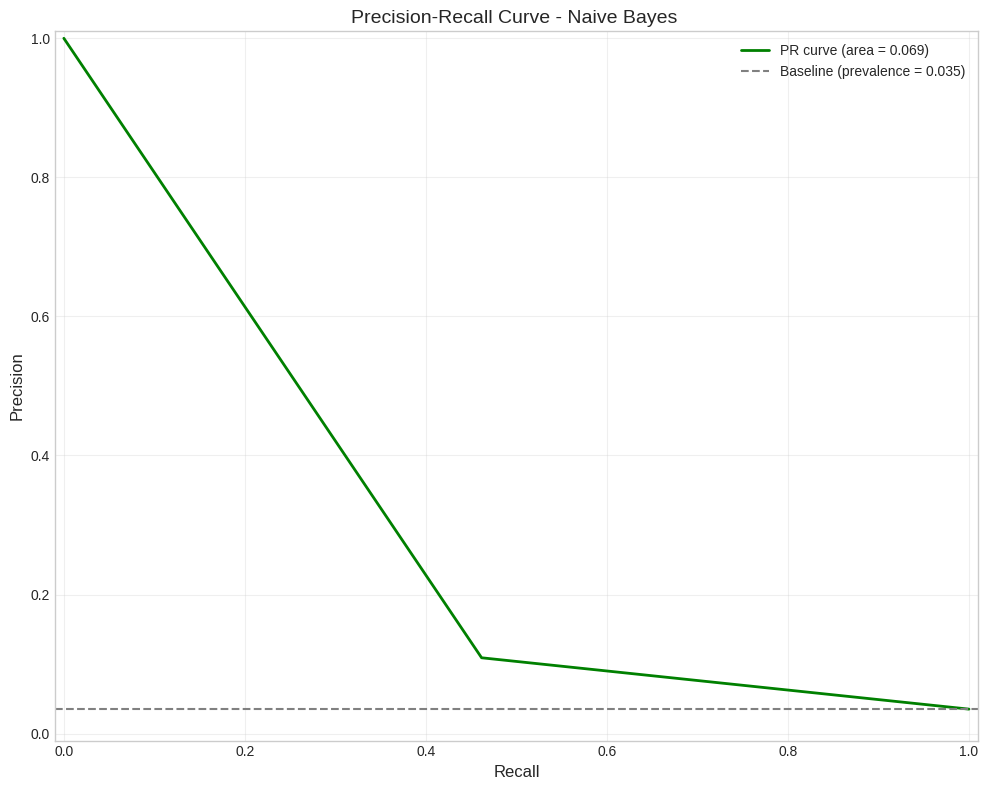

In [34]:

print("\n Training Naive Bayes model  ")
nb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GaussianNB())
])

nb_pipeline.fit(X_train, y_train)
nb_metrics = evaluate_model(nb_pipeline, X_test, y_test, "Naive Bayes ")
all_model_results.append(nb_metrics)


### 6.7 Neural Network




 Training Neural Network model  

Neural Network  Evaluation:
Accuracy: 0.9295
Precision: 0.1905
Recall: 0.3077
F1 Score: 0.2353
ROC AUC: 0.7998
PR AUC: 0.2145

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       356
           1       0.19      0.31      0.24        13

    accuracy                           0.93       369
   macro avg       0.58      0.63      0.60       369
weighted avg       0.95      0.93      0.94       369


Confusion Matrix:
[[339  17]
 [  9   4]]


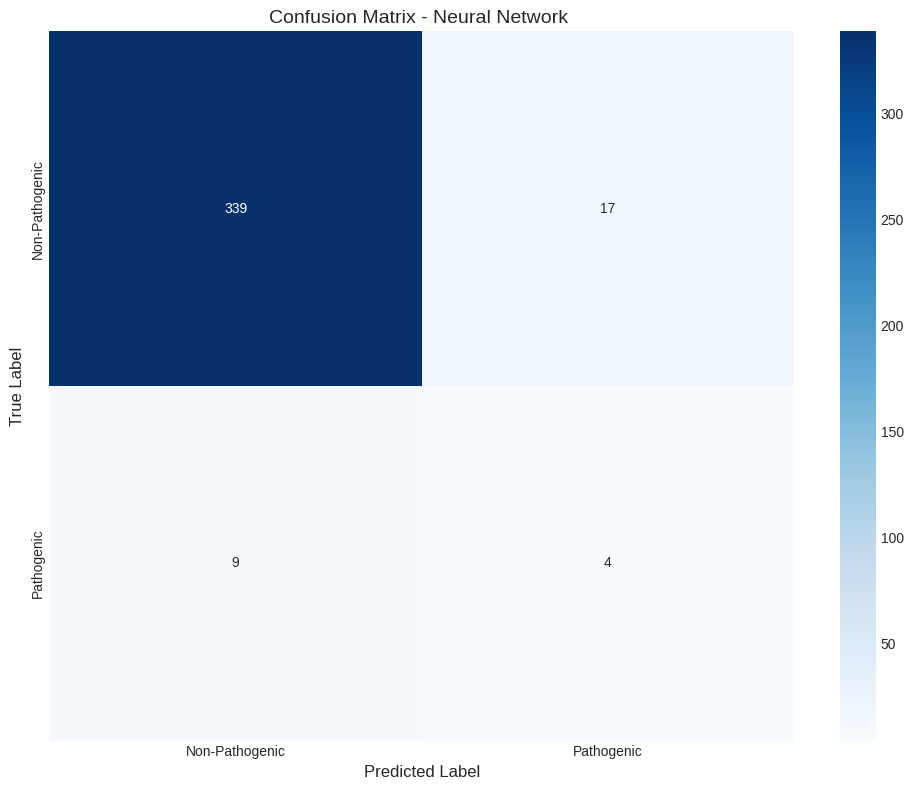

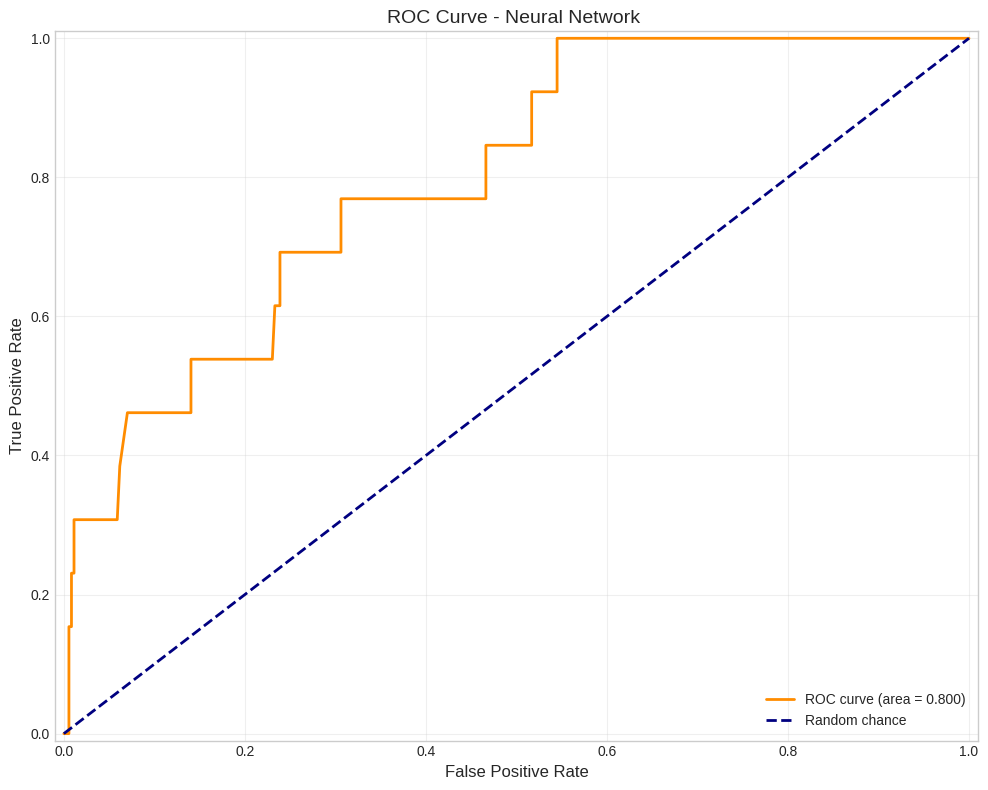

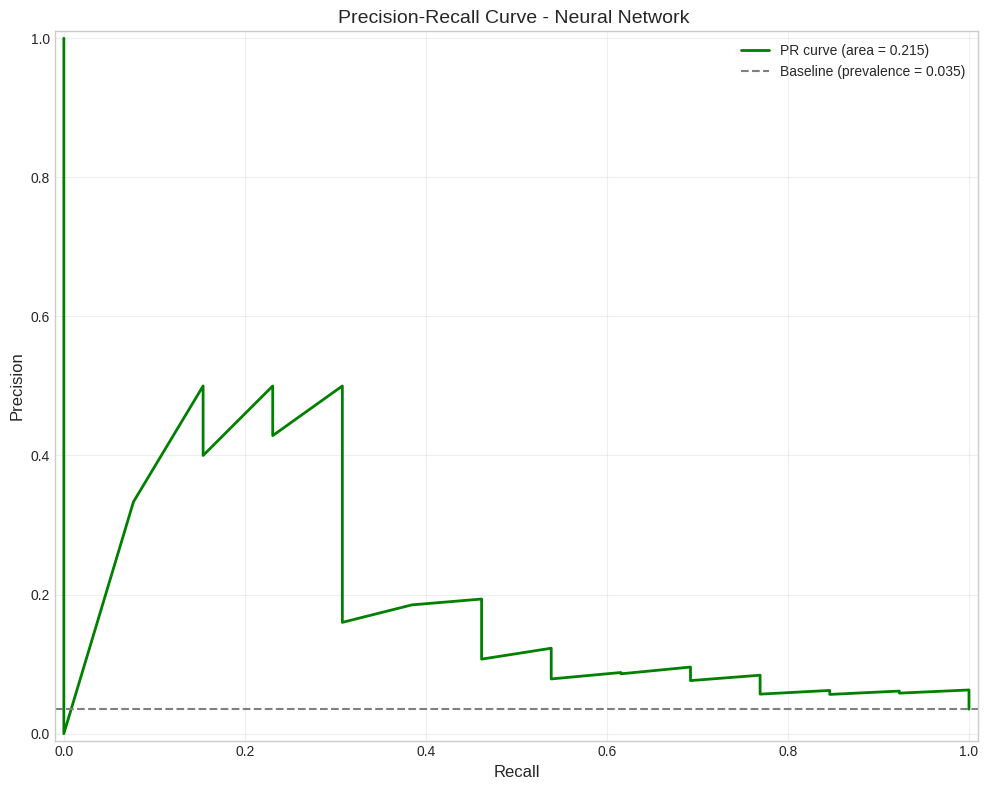

In [35]:
print("\n Training Neural Network model  ")
nn_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42
    ))
])

nn_pipeline.fit(X_train, y_train)
nn_metrics = evaluate_model(nn_pipeline, X_test, y_test, "Neural Network ")
all_model_results.append(nn_metrics)


### 6.8 Voting Ensemble



 Training Voting Classifier Ensemble 

Voting Ensemble  Evaluation:
Accuracy: 0.9377
Precision: 0.2222
Recall: 0.3077
F1 Score: 0.2581
ROC AUC: 0.8658
PR AUC: 0.3337

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       356
           1       0.22      0.31      0.26        13

    accuracy                           0.94       369
   macro avg       0.60      0.63      0.61       369
weighted avg       0.95      0.94      0.94       369


Confusion Matrix:
[[342  14]
 [  9   4]]


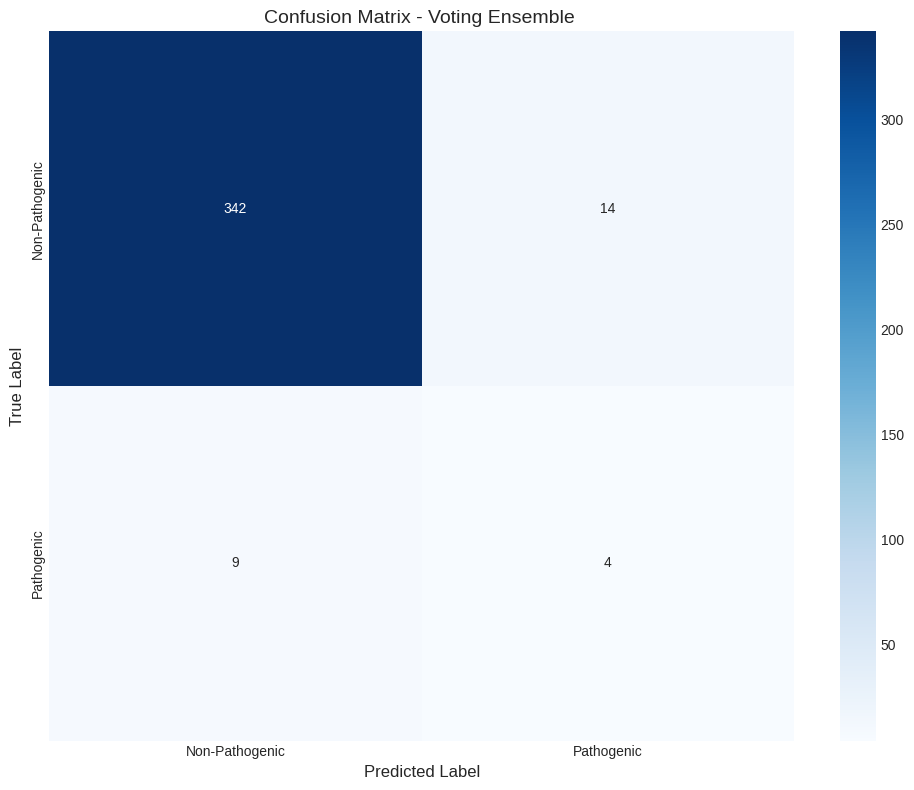

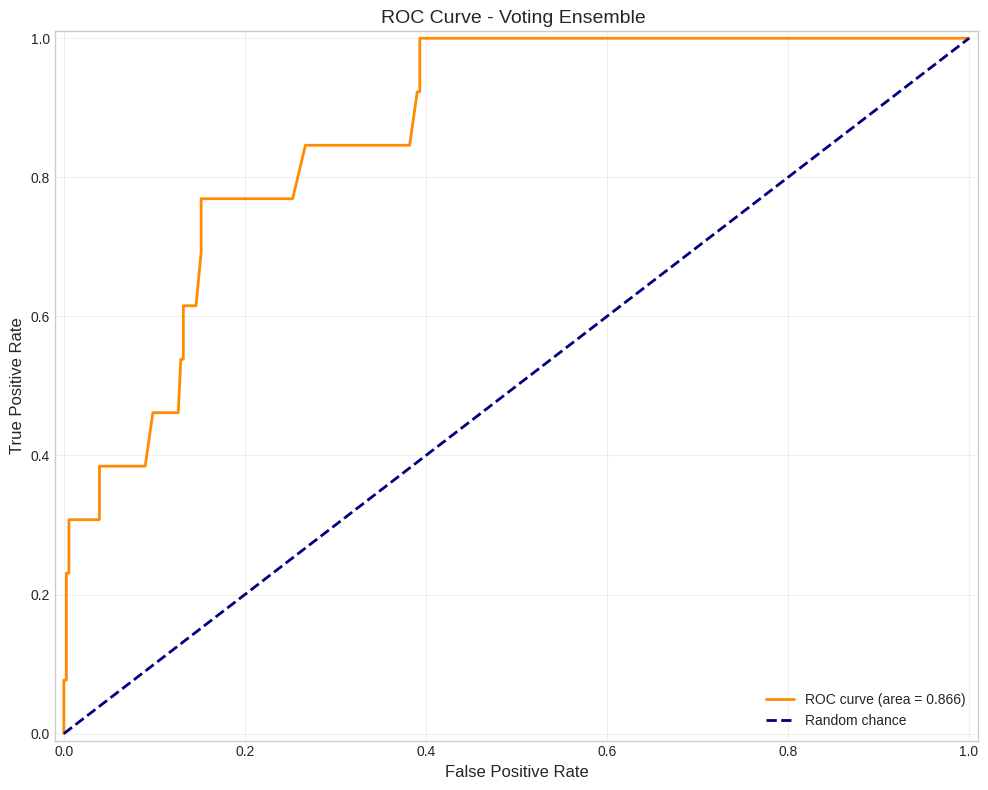

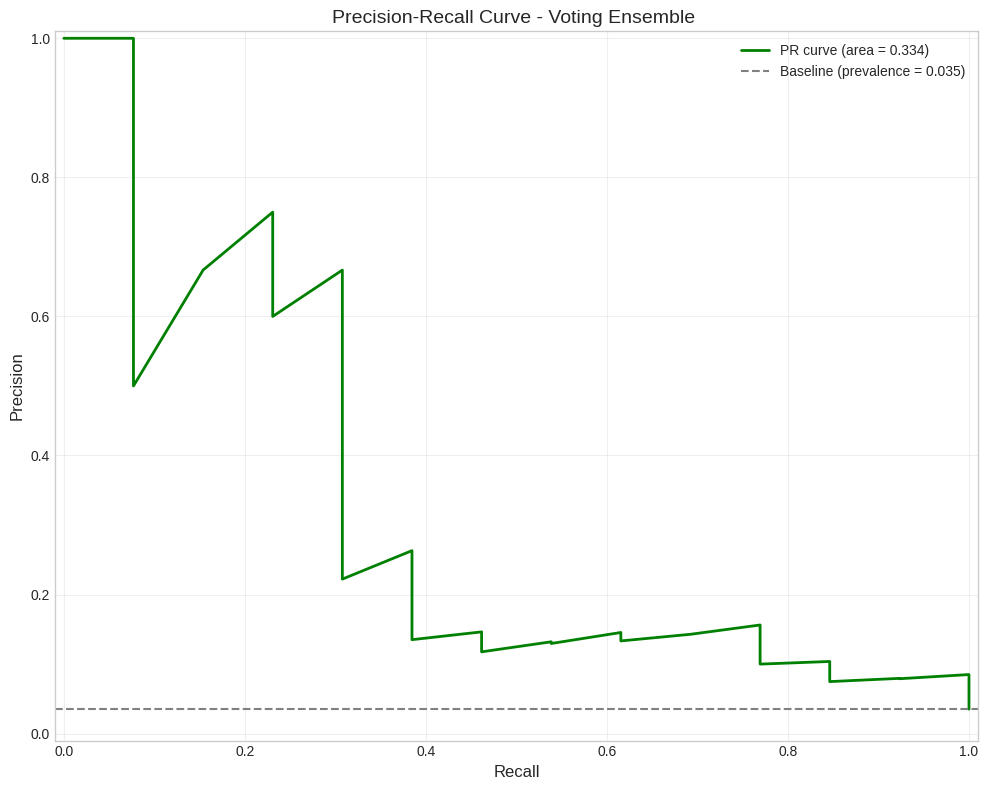

In [36]:
print("\n Training Voting Classifier Ensemble ")
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42))
], voting='soft')

voting_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', voting_clf)
])

voting_pipeline.fit(X_train, y_train)
voting_metrics = evaluate_model(voting_pipeline, X_test, y_test, "Voting Ensemble ")
all_model_results.append(voting_metrics)


### 6.9 Stacking Ensemble



 Training Stacking Ensemble 

Stacking Ensemble  Evaluation:
Accuracy: 0.9485
Precision: 0.3125
Recall: 0.3846
F1 Score: 0.3448
ROC AUC: 0.7676
PR AUC: 0.3147

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       356
           1       0.31      0.38      0.34        13

    accuracy                           0.95       369
   macro avg       0.64      0.68      0.66       369
weighted avg       0.95      0.95      0.95       369


Confusion Matrix:
[[345  11]
 [  8   5]]


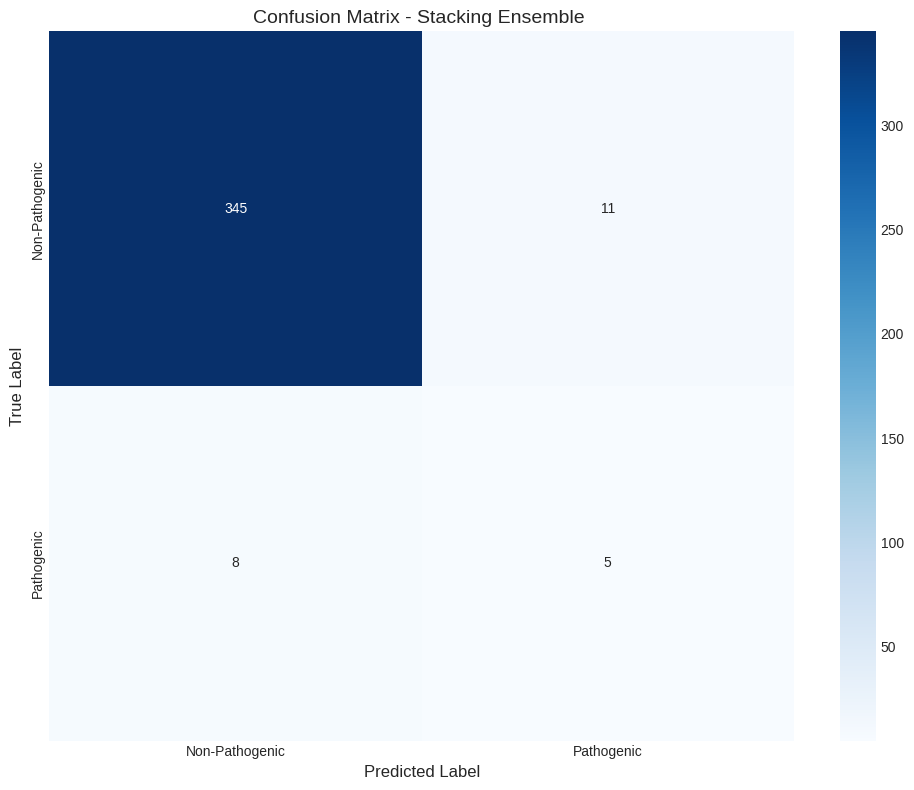

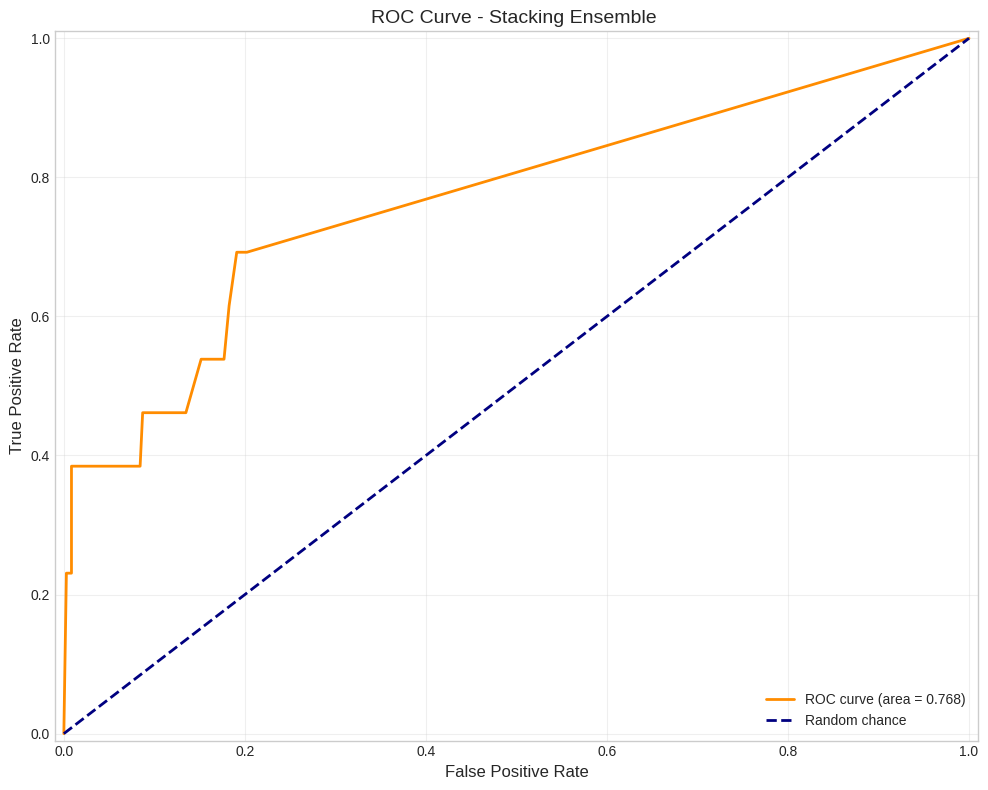

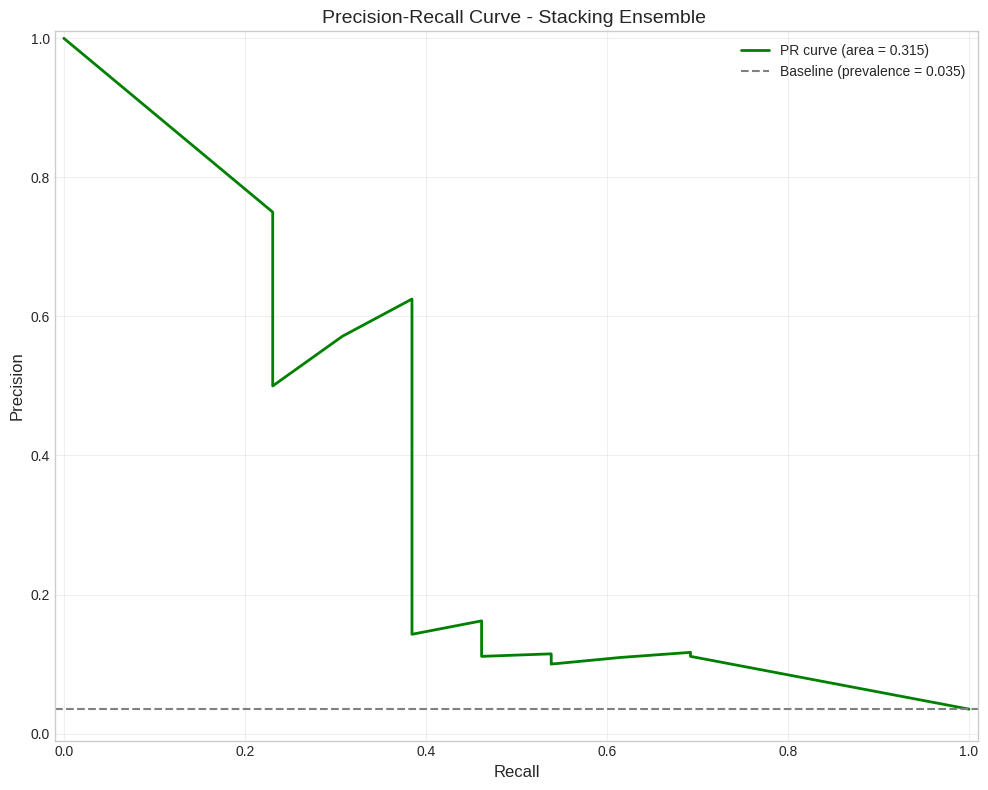

In [37]:

print("\n Training Stacking Ensemble ")
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=50, random_state=42))
]

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    cv=5
)

stacking_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', stacking_clf)
])

stacking_pipeline.fit(X_train, y_train)
stacking_metrics = evaluate_model(stacking_pipeline, X_test, y_test, "Stacking Ensemble ")
all_model_results.append(stacking_metrics)


# 7. Compare all models


In [38]:

print("\n Model Comparison ")
results_df = pd.DataFrame(all_model_results)
print(results_df.sort_values('f1', ascending=False))



 Model Comparison 
               model_name  accuracy  precision    recall        f1   roc_auc  \
4                XGBoost   0.948509   0.312500  0.384615  0.344828  0.889801   
8      Stacking Ensemble   0.948509   0.312500  0.384615  0.344828  0.767610   
0          Random Forest   0.945799   0.266667  0.307692  0.285714  0.770095   
7        Voting Ensemble   0.937669   0.222222  0.307692  0.258065  0.865817   
6         Neural Network   0.929539   0.190476  0.307692  0.235294  0.799806   
3      Gradient Boosting   0.924119   0.173913  0.307692  0.222222  0.837943   
5            Naive Bayes   0.848238   0.109091  0.461538  0.176471  0.661949   
1  Balanced Random Forest  0.737127   0.096154  0.769231  0.170940  0.869814   
2               AdaBoost   0.837398   0.056604  0.230769  0.090909  0.797213   

     pr_auc  
4  0.413808  
8  0.314672  
0  0.308497  
7  0.333668  
6  0.214518  
3  0.248628  
5  0.069320  
1  0.380098  
2  0.190061  


## 8. Feature Importance for best model

In [39]:

best_model_idx = results_df['f1'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model_name']
print(f"\n Feature Importance Analysis for {best_model_name} ")

if 'Random Forest' in best_model_name and 'Balanced' not in best_model_name:
    best_pipeline = rf_pipeline
elif 'Balanced Random Forest' in best_model_name:
    best_pipeline = brf_pipeline
elif 'AdaBoost' in best_model_name:
    best_pipeline = ada_pipeline
elif 'Gradient Boosting' in best_model_name:
    best_pipeline = gb_pipeline
elif 'XGBoost' in best_model_name:
    best_pipeline = xgb_pipeline
elif 'Naive Bayes' in best_model_name:
    best_pipeline = nb_pipeline
elif 'Neural Network' in best_model_name:
    best_pipeline = nn_pipeline
elif 'Voting' in best_model_name:
    best_pipeline = voting_pipeline
elif 'Stacking' in best_model_name:
    best_pipeline = stacking_pipeline
else:
    best_pipeline = rf_pipeline

try:
    cat_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
    feature_names = numerical_features + list(cat_features)

    best_model = best_pipeline.named_steps['classifier']
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print("\nTop 20 most important features:")
        print(importance_df.head(20))
    else:
        print(f"Feature importance not available for {best_model_name}")
except Exception as e:
    print(f"Error getting feature importances: {e}")



 Feature Importance Analysis for XGBoost  

Top 20 most important features:
                         Feature  Importance
28                  gram_unknown    0.294416
71     klass_Deltaproteobacteria    0.058811
2          phylum_Actinobacteria    0.045018
49                 shape_Bacilli    0.038451
16           phylum_Spirochaetes    0.034000
421         genus_Clostridioides    0.033764
545          genus_Mycobacterium    0.032801
5              phylum_Chlamydiae    0.028651
105      order_Campylobacterales    0.026210
397               genus_Brucella    0.024009
34   oxygen_requirement_Anaerobe    0.022877
190        family_Bartonellaceae    0.020882
132          order_Legionellales    0.020195
66              klass_Clostridia    0.015833
304     family_Staphylococcaceae    0.015495
616               genus_Shigella    0.014981
131        order_Lactobacillales    0.013768
153          order_Rickettsiales    0.013087
662               genus_Yersinia    0.011809
48    oxygen_requiremen

## 9. Hyperparameter tuning for the best model


 Hyperparameter Tuning for XGBoost  
Tuning XGBoost...
Running grid search (this may take some time)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits



Best parameters:
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

Best F1 score: 0.1609

Evaluating tuned model on test set:

XGBoost  (Tuned) Evaluation:
Accuracy: 0.6829
Precision: 0.0938
Recall: 0.9231
F1 Score: 0.1702
ROC AUC: 0.8633
PR AUC: 0.3138

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80       356
           1       0.09      0.92      0.17        13

    accuracy                           0.68       369
   macro avg       0.54      0.80      0.49       369
weighted avg       0.96      0.68      0.78       369


Confusion Matrix:
[[240 116]
 [  1  12]]


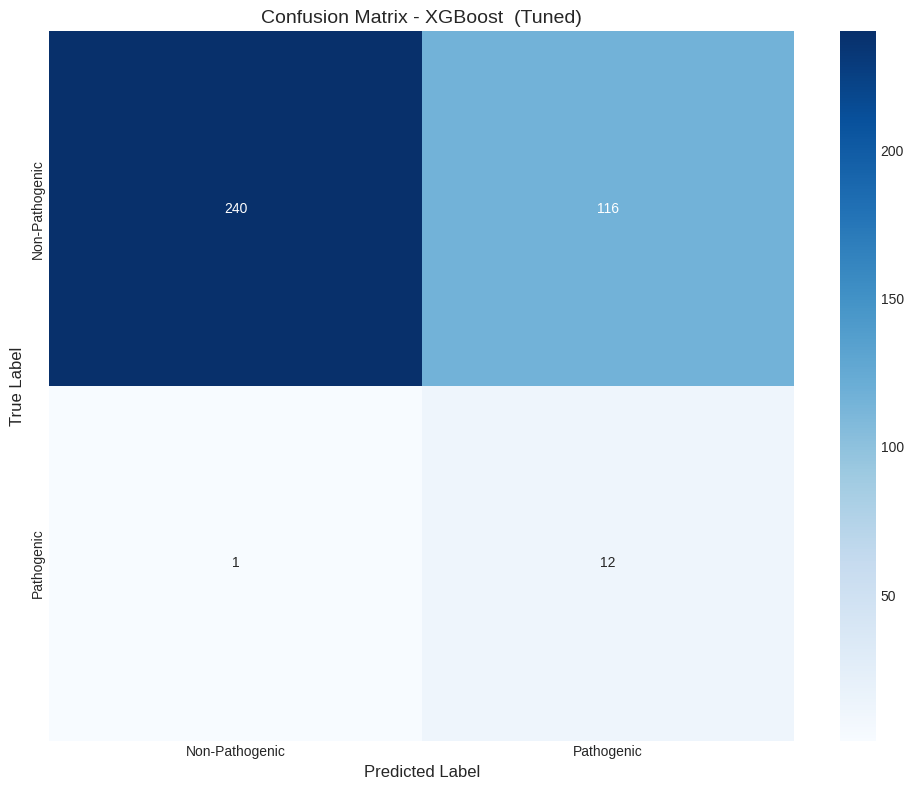

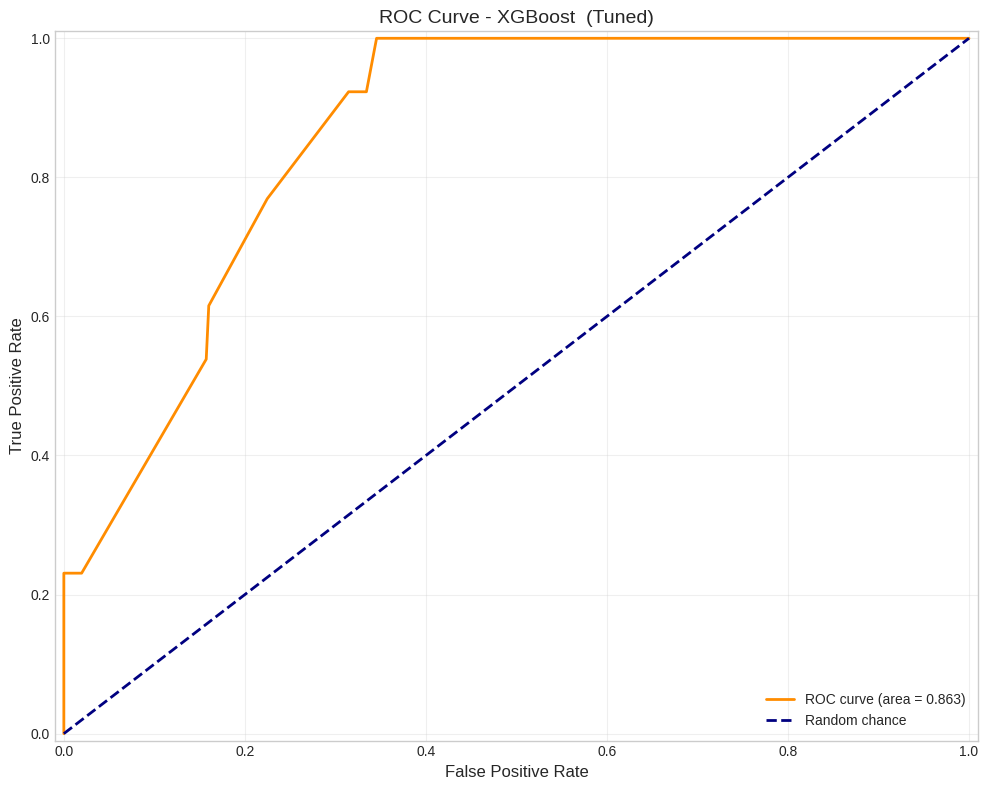

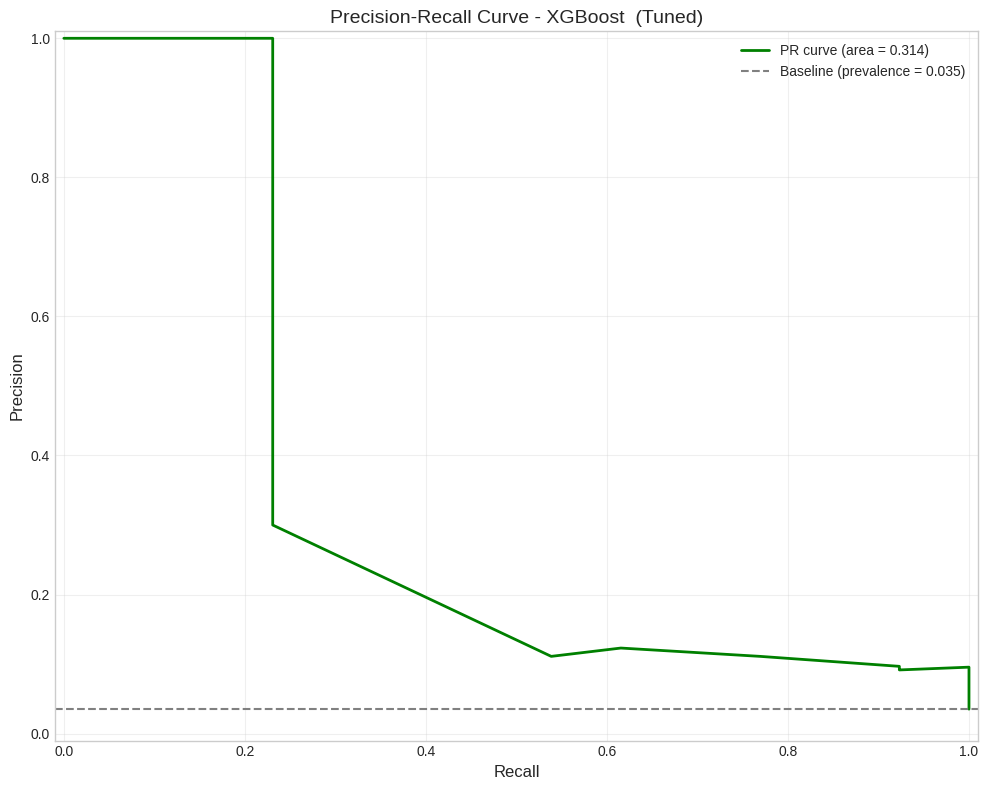


 Final Model Comparison (including tuned model) 
               model_name  accuracy  precision    recall        f1   roc_auc  \
8      Stacking Ensemble   0.948509   0.312500  0.384615  0.344828  0.767610   
4                XGBoost   0.948509   0.312500  0.384615  0.344828  0.889801   
0          Random Forest   0.945799   0.266667  0.307692  0.285714  0.770095   
7        Voting Ensemble   0.937669   0.222222  0.307692  0.258065  0.865817   
6         Neural Network   0.929539   0.190476  0.307692  0.235294  0.799806   
3      Gradient Boosting   0.924119   0.173913  0.307692  0.222222  0.837943   
5            Naive Bayes   0.848238   0.109091  0.461538  0.176471  0.661949   
1  Balanced Random Forest  0.737127   0.096154  0.769231  0.170940  0.869814   
9        XGBoost  (Tuned)  0.682927   0.093750  0.923077  0.170213  0.863332   
2               AdaBoost   0.837398   0.056604  0.230769  0.090909  0.797213   

     pr_auc  
8  0.314672  
4  0.413808  
0  0.308497  
7  0.333668  

In [40]:

print(f"\n Hyperparameter Tuning for {best_model_name} ")

if 'Random Forest' in best_model_name and 'Balanced' not in best_model_name:
    print("Tuning Random Forest...")
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    }
elif 'Balanced Random Forest' in best_model_name:
    print("Tuning Balanced Random Forest...")
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    }
elif 'AdaBoost' in best_model_name:
    print("Tuning AdaBoost...")
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 1.0]
    }
elif 'Gradient Boosting' in best_model_name:
    print("Tuning Gradient Boosting...")
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    }
elif 'XGBoost' in best_model_name:
    print("Tuning XGBoost...")
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5, 7]
    }
elif 'Neural Network' in best_model_name:
    print("Tuning Neural Network...")
    param_grid = {
        'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'classifier__alpha': [0.0001, 0.001, 0.01]
    }
else:
    print(f"Hyperparameter tuning grid not defined for {best_model_name}")
    param_grid = {}

if param_grid:
    grid_search = GridSearchCV(
        best_pipeline,
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    print("Running grid search (this may take some time)...")
    grid_search.fit(X, y)

    print("\nBest parameters:")
    print(grid_search.best_params_)
    print(f"\nBest F1 score: {grid_search.best_score_:.4f}")

    best_model_tuned = grid_search.best_estimator_

    print("\nEvaluating tuned model on test set:")
    tuned_metrics = evaluate_model(best_model_tuned, X_test, y_test, f"{best_model_name} (Tuned)")

    all_model_results.append(tuned_metrics)

    print("\n Final Model Comparison (including tuned model) ")
    final_results_df = pd.DataFrame(all_model_results)
    print(final_results_df.sort_values('f1', ascending=False))

    output_file = f'../ml/models/bacteria_classifier_{best_model_name.replace(" ", "_").lower()}_tuned.pkl'
    joblib.dump(best_model_tuned, output_file)
    print(f"\nTuned model saved to: {output_file}")
else:
    output_file = f'../ml/models/bacteria_classifier_{best_model_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(best_pipeline, output_file)
    print(f"\nBest model saved to: {output_file}")


## 10. Final summary


In [41]:

print("\n Summary ")
print(f"Best performing model: {best_model_name}")
if param_grid:
    print(f"Best parameters: {grid_search.best_params_}")
    best_idx = len(all_model_results) - 1
else:
    best_idx = best_model_idx

best_metrics = all_model_results[best_idx]
print(f"Performance metrics:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    if metric in best_metrics and not np.isnan(best_metrics[metric]):
        print(f"- {metric}: {best_metrics[metric]:.4f}")

print("\nModel training and evaluation complete!")


 Summary 
Best performing model: XGBoost 
Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Performance metrics:
- accuracy: 0.6829
- precision: 0.0938
- recall: 0.9231
- f1: 0.1702
- roc_auc: 0.8633

Model training and evaluation complete!
